# Classification - Airline company satisfaction

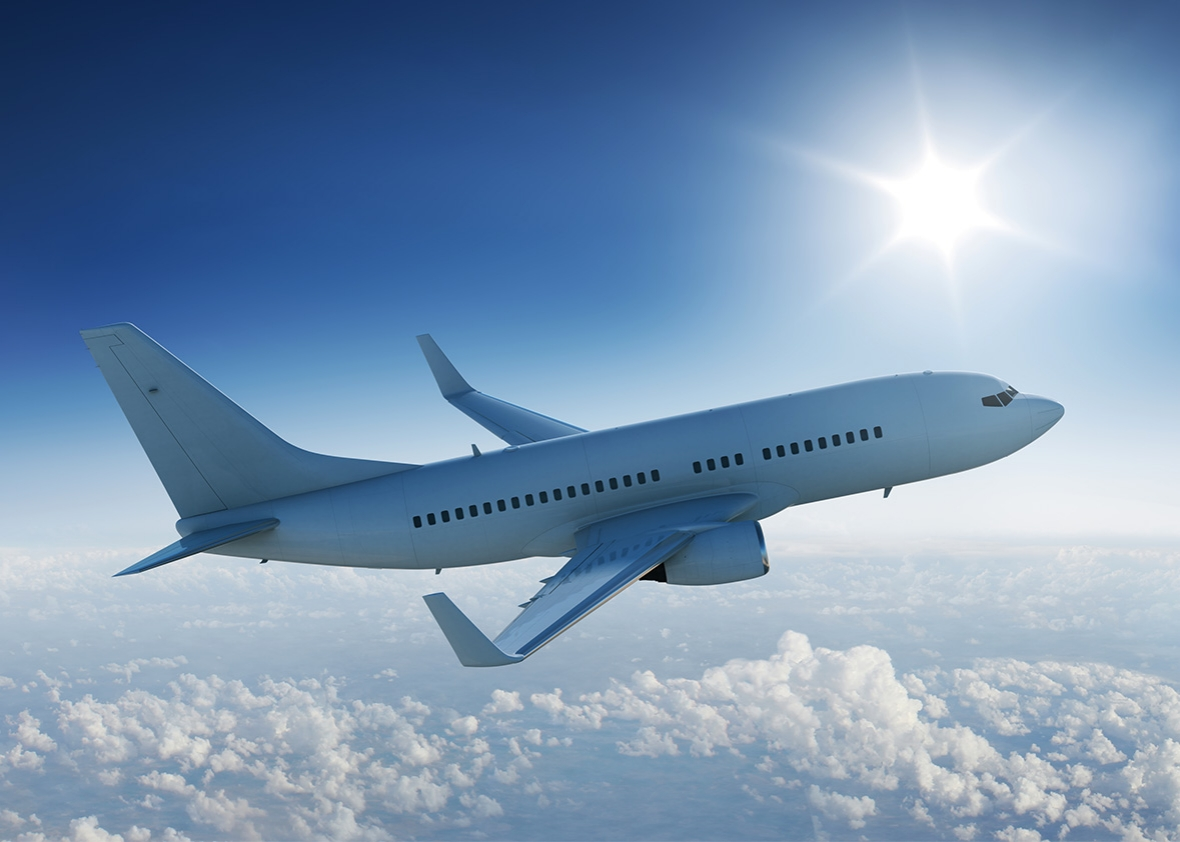

## Main goal
Given a customers and flight details, we need to predict if the customer was 'sattisfied' (1) or 'neutral or dissatisfied' (0).

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## Creating the Dataframe
We took the data from kaggle, the data there was splitted to train and test parts, we decided to unite them and split by ourselves.

In [2]:
df1 = pd.read_csv('C:/Users/matan/Data Science Project/train.csv')
df2 = pd.read_csv('C:/Users/matan/Data Science Project/test.csv')
df = pd.concat([df1, df2])

In [3]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Let's check if we have NaN values:

In [4]:
df.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction    

As we can see from above, we have 393 NaN values in 'Arrival Delay in Minutes', therefore we will remove all of those values, and by that, we will also remove the whole line data.

In [5]:
df = df.dropna()

In [6]:
df.shape

(129487, 25)

Great, we have a lot of travelers in our data.

Let's check if we have duplicated data:

In [7]:
df.duplicated().sum()

0

Awesome, no duplicated data.

Note: the reason we checked if the whole line is duplicated and not only on the id, because people can vote differently in each flight they have.

Let's check the distribution of the 'satisfaction' column:

In [8]:
df.groupby('satisfaction').size()

satisfaction
neutral or dissatisfied    73225
satisfied                  56262
dtype: int64

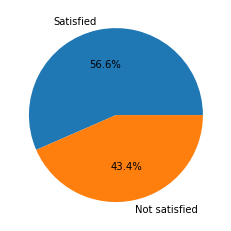

In [9]:
satisfied = 73225
not_satisfied = 56262
plt.pie([satisfied, not_satisfied], labels=['Satisfied','Not satisfied'], autopct='%1.1f%%')
plt.show()

From here we can understand that if we'll make a DummyClassfierModel that always says the person always will be satisfied, that model we'll score in 56.6%.

In [10]:
df["satisfaction"].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

As we can see, the 'satisfaction' column has two text options, let's change it to numerical values:

In [11]:
df["satisfaction"].replace({"neutral or dissatisfied": 0, "satisfied": 1}, inplace=True)
df["satisfaction"].astype("int64")

0        0
1        0
2        1
3        0
4        1
        ..
25971    0
25972    1
25973    0
25974    1
25975    0
Name: satisfaction, Length: 129487, dtype: int64

Before continuing changing the text to numerical values, we presented some interesting graphs.

## Data exploring

Let's check which gender has the highest satisfaction percent:

In [12]:
genders = df.groupby(['Gender']).agg({'satisfaction':'sum'})
genders['num_of_travelers'] = df.groupby(['Gender']).count()['satisfaction']
genders['Average'] = genders['satisfaction'] / genders['num_of_travelers']

In [13]:
genders

,satisfaction,num_of_travelers,Average
Gender,,,
Female,28179,65703,0.428885
Male,28083,63784,0.440283


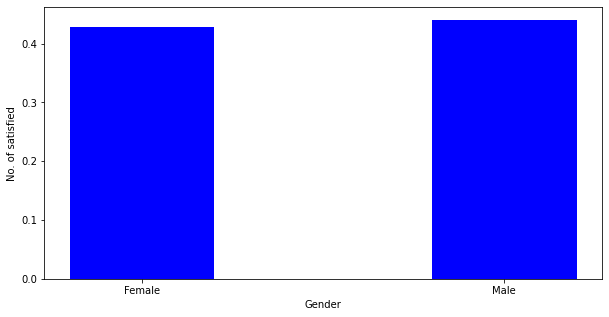

In [14]:
x = genders.index
y = genders.Average
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='blue',width = 0.4)
plt.xlabel("Gender")
plt.ylabel("No. of satisfied")
plt.show()

As we can see from the graph, the males have a little more satifaction percent than the females, from here we can also understand that the correlation between those columns ('Gender', 'satisfaction') will be low.

Let's check which 'Customer Type' has the highest satisfaction percent:

In [15]:
customer_types = df.groupby(['Customer Type']).agg({'satisfaction':'sum'})
customer_types['num_of_travelers'] = df.groupby(['Customer Type']).count()['satisfaction']
customer_types['Average'] = customer_types['satisfaction'] / customer_types['num_of_travelers']

In [16]:
customer_types

,satisfaction,num_of_travelers,Average
Customer Type,,,
Loyal Customer,50574,105773,0.478137
disloyal Customer,5688,23714,0.239858


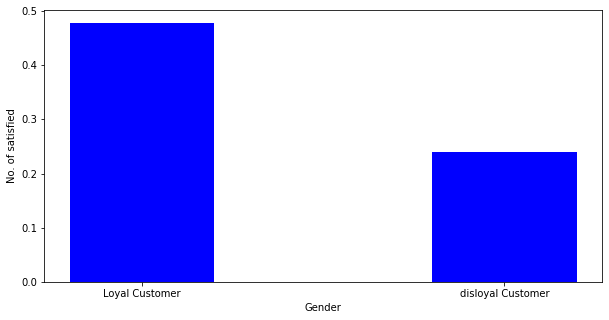

In [17]:
x = customer_types.index
y = customer_types.Average
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='blue',width = 0.4)
plt.xlabel("Gender")
plt.ylabel("No. of satisfied")
plt.show()

As we can see from the graph, the 'Loyal customers' have more satifaction percent than the 'disloyal customers', from here we can also understand that the we have some corrlation bewteen those columns ('Customer Type', 'satisfaction').

Let's check which 'Type of Travel' has the highest satisfaction percent:

In [18]:
travel_types = df.groupby(['Type of Travel']).agg({'satisfaction':'sum'})
travel_types['num_of_travelers'] = df.groupby(['Type of Travel']).count()['satisfaction']
travel_types['Average'] = travel_types['satisfaction'] / travel_types['num_of_travelers']

In [19]:
travel_types

,satisfaction,num_of_travelers,Average
Type of Travel,,,
Business travel,52207,89445,0.583677
Personal Travel,4055,40042,0.101269


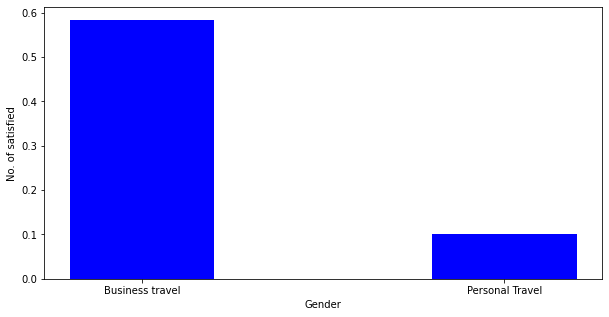

In [20]:
x = travel_types.index
y = travel_types.Average
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='blue',width = 0.4)
plt.xlabel("Gender")
plt.ylabel("No. of satisfied")
plt.show()

As we can see from the graph, the 'Business travelers' have way more satifaction percent than the 'personal Travelers' (that's make sense, because they (Business travelers) get better service), from here we can also understand that the we'll have more corrlation bewteen those columns ('Type of Travel	', 'satisfaction') than the columns we mentioned before ('Customer Type', 'satisfaction').

Let's check which age (by decade) has the highest complaining percent:

In [21]:
ages_by_decade = df.copy()
ages_by_decade['Age'] = ages_by_decade['Age'] // 10
ages_by_decade.rename(columns={"Age":"Age (by decade)"})
ages_by_decade.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,1,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,0
1,1,5047,Male,disloyal Customer,2,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,0
2,2,110028,Female,Loyal Customer,2,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,3,24026,Female,Loyal Customer,2,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,0
4,4,119299,Male,Loyal Customer,6,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [22]:
ages = ages_by_decade.groupby(['Age']).agg({'satisfaction':'sum'})
ages['num_of_travelers'] = ages_by_decade.groupby(['Age']).count()['satisfaction']
ages['Average'] = (ages['num_of_travelers'] - ages['satisfaction']) / ages['num_of_travelers']

In [23]:
ages

,satisfaction,num_of_travelers,Average
Age,,,
0,270,2327,0.883971
1,1963,9814,0.799980
2,9322,26098,0.642808
3,10573,25623,0.587363
4,17154,29555,0.419591
5,13692,23902,0.427161
6,2904,10442,0.721892
7,347,1591,0.781898
8,37,135,0.725926


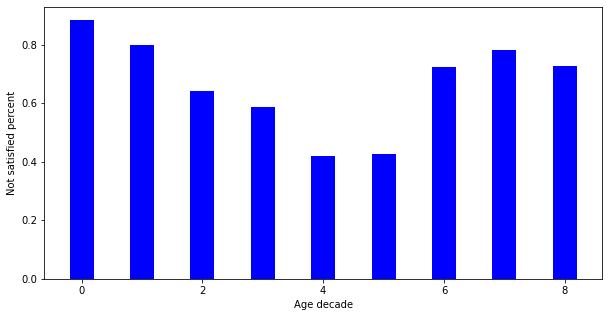

In [24]:
x = ages.index
y = ages.Average
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color ='blue',width = 0.4)
plt.xlabel("Age decade")
plt.ylabel("Not satisfied percent")
plt.show()

From here we can see that kids (Age < 20) has the highest percent of unsatisfaction, maybe the airline company should consider adding video games options during the flight :) 

We can see the correlation preciesly, and more, in a correlation map.

First we we'll finish changing text data to numerical.

## Changing from text to numerical

In [25]:
df["Gender"].unique()

array(['Male', 'Female'], dtype=object)

In [26]:
df["Gender"].replace({"Female": 0, "Male": 1}, inplace=True)
df["Gender"].astype("int64")

0        1
1        1
2        0
3        0
4        1
        ..
25971    1
25972    1
25973    0
25974    1
25975    0
Name: Gender, Length: 129487, dtype: int64

In [27]:
df["Customer Type"].unique()

array(['Loyal Customer', 'disloyal Customer'], dtype=object)

In [28]:
df["Customer Type"].replace({"disloyal Customer": 0, "Loyal Customer": 1}, inplace=True)
df["Customer Type"].astype("int64")

0        1
1        0
2        1
3        1
4        1
        ..
25971    0
25972    1
25973    1
25974    1
25975    1
Name: Customer Type, Length: 129487, dtype: int64

In [29]:
df["Type of Travel"].unique()

array(['Personal Travel', 'Business travel'], dtype=object)

In [30]:
df["Type of Travel"].replace({"Personal Travel": 0, "Business travel": 1}, inplace=True)
df["Type of Travel"].astype("int64")

0        0
1        1
2        1
3        1
4        1
        ..
25971    1
25972    1
25973    0
25974    1
25975    0
Name: Type of Travel, Length: 129487, dtype: int64

In [31]:
df["Class"].unique()

array(['Eco Plus', 'Business', 'Eco'], dtype=object)

In [32]:
df["Class"].replace({"Eco": 0, "Eco Plus": 1, "Business":2}, inplace=True)
df["Class"].astype("int64")

0        1
1        2
2        2
3        2
4        2
        ..
25971    2
25972    2
25973    0
25974    2
25975    0
Name: Class, Length: 129487, dtype: int64

## Correlation matrix
The correlation matrix (heatmap) is so important because from it we can see which columns are more correlated to others, And in particular, to the 'satisfication' column.

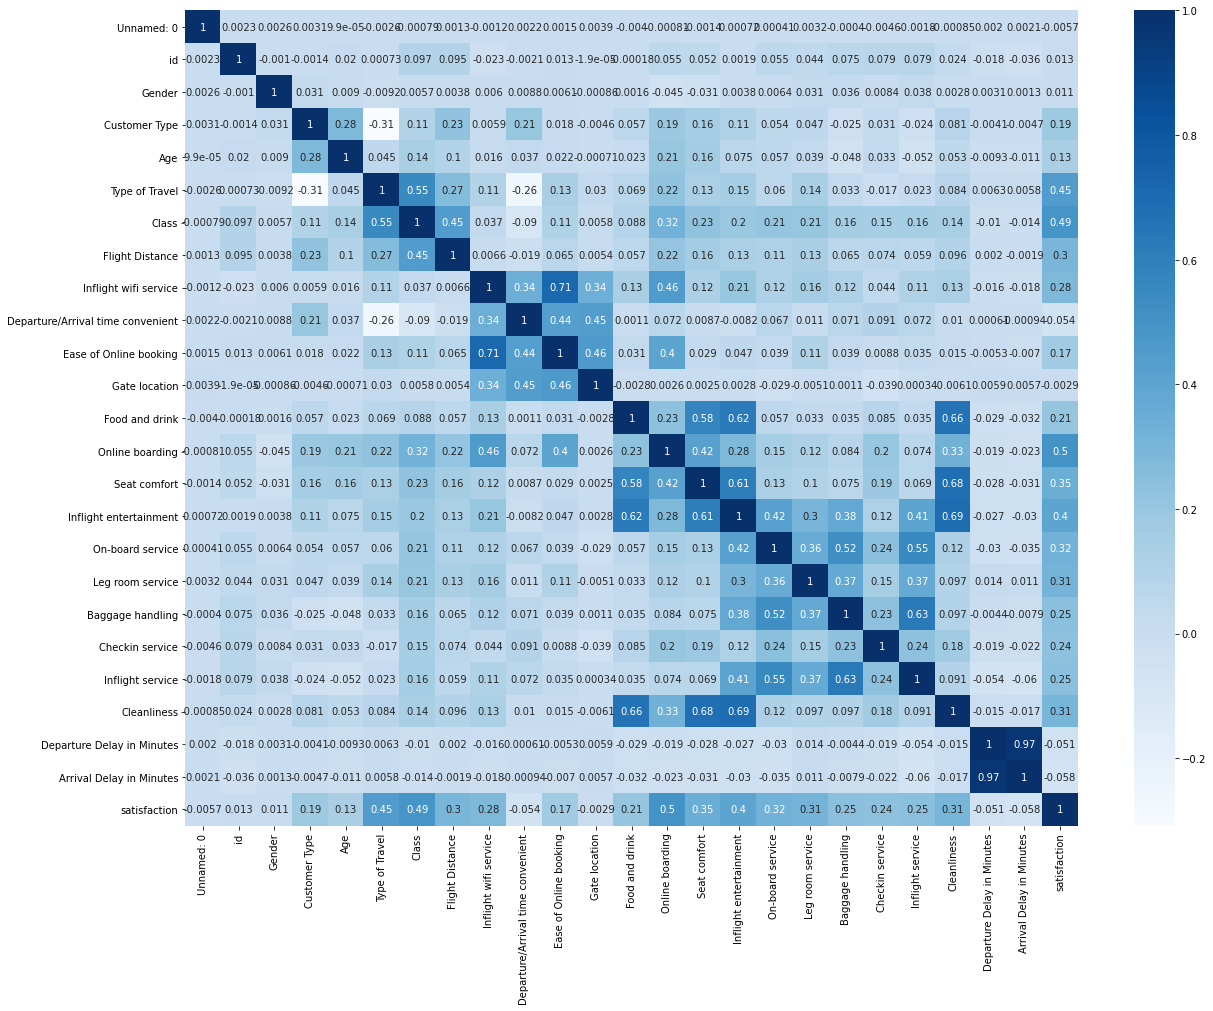

In [33]:
plt.figure(figsize=(20, 15))
sb.heatmap(df.corr(), annot=True, cmap="Blues");

From here we can see that as we thought: the 'Gender' has very little correlation (0.011) to the 'satisfication', while the 'Customer Type' has higher than him (0.19) and the 'Type of Travel' has more correlation (0.45) than the 'Customer Type'.

We can also see that we have 0.3 correlation between the 'Flight Distance' to the 'satisfication', meaning that there is dependency between the satisfication of the traverels to our target.

Moreover, the heatmap shows us that the feature with highest correlation between the given features to our target is 'Online boarding', from here we can understand that probably the boarding customer in the airport is bad or that the people who boared online has probabl a better seat, and from here we can understand that the real correlation is the seat itself.

## Scaling
After we removed all of the NaN values and changed all of the text value to numerical data, we can scale our data.
### Normalization
Before we split the data into train and test sets, we must scale the values, we chose doing that by normalization.

In [34]:
cols = list(df.columns)
cols.remove('satisfaction')
basic_scale = MinMaxScaler()
df[cols] = basic_scale.fit_transform(df[cols])

In [35]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0.000000,0.540280,1.0,1.0,0.076923,0.0,0.5,0.086632,0.6,0.8,...,1.0,0.8,0.6,0.75,0.8,1.0,1.0,0.015704,0.011364,0
1,0.000010,0.038852,1.0,0.0,0.230769,1.0,1.0,0.041195,0.6,0.4,...,0.2,0.2,1.0,0.50,0.2,0.8,0.2,0.000628,0.003788,0
2,0.000019,0.847150,0.0,1.0,0.243590,1.0,1.0,0.224354,0.4,0.4,...,1.0,0.8,0.6,0.75,0.8,0.8,1.0,0.000000,0.000000,1
3,0.000029,0.184980,0.0,1.0,0.230769,1.0,1.0,0.107229,0.4,1.0,...,0.4,0.4,1.0,0.50,0.2,0.8,0.4,0.006910,0.005682,0
4,0.000038,0.918532,1.0,1.0,0.692308,1.0,1.0,0.036955,0.6,0.6,...,0.6,0.6,0.8,0.75,0.6,0.6,0.6,0.000000,0.000000,1


As we can see, the data is now normalized.

## Spliting the data into train and test parts¶
Now, after we scaled the data, we can split it.

The train_test_split() method splits the data according to a random state, if we'll choose some random state, than over multiple reruns, the resulting dataframes from the method remain the same (we chose random state 7).

In [36]:
targets = df['satisfaction']
data_without_targets = df.drop(['satisfaction'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(data_without_targets, targets, test_size=0.2, random_state = 7)

In [37]:
X_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
25809,0.248395,0.810046,1.0,1.0,0.461538,1.0,1.0,0.506462,0.2,0.2,...,0.8,0.8,0.8,0.8,0.75,0.8,0.8,1.0,0.000000,0.000000
18427,0.177348,0.180029,1.0,1.0,0.205128,0.0,0.5,0.198506,0.6,0.6,...,0.8,0.8,0.8,1.0,0.25,0.6,0.6,0.8,0.033291,0.027778
103420,0.995351,0.916961,0.0,1.0,0.217949,1.0,0.0,0.199717,0.6,0.2,...,0.4,0.6,0.8,0.6,0.50,0.4,0.8,0.6,0.000000,0.000000
2624,0.025254,0.612786,1.0,0.0,0.256410,1.0,1.0,0.147617,0.8,0.8,...,0.2,0.2,0.8,0.4,1.00,1.0,0.8,0.2,0.000000,0.000000
16145,0.155385,0.350049,1.0,1.0,0.346154,1.0,1.0,0.658118,1.0,1.0,...,0.6,0.8,0.8,1.0,0.75,0.8,0.8,0.8,0.018216,0.011995


In [38]:
X_train.describe()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,...,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000,103589.000000
mean,0.424901,0.501113,0.492292,0.817635,0.415686,0.690334,0.515108,0.234385,0.546313,0.612275,...,0.688631,0.672091,0.677282,0.670683,0.658820,0.661999,0.729164,0.657209,0.009173,0.009512
std,0.300482,0.288734,0.499943,0.386147,0.193733,0.462358,0.481418,0.201358,0.265593,0.305214,...,0.263764,0.266818,0.257369,0.263115,0.294793,0.253013,0.235197,0.262753,0.023716,0.024194
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.156126,0.250910,0.000000,1.000000,0.256410,0.000000,0.000000,0.077342,0.400000,0.400000,...,0.400000,0.400000,0.400000,0.400000,0.500000,0.600000,0.600000,0.400000,0.000000,0.000000
50%,0.375244,0.501806,0.000000,1.000000,0.423077,1.000000,0.500000,0.164580,0.600000,0.600000,...,0.800000,0.800000,0.800000,0.800000,0.750000,0.600000,0.800000,0.600000,0.000000,0.000000
75%,0.687295,0.751215,1.000000,1.000000,0.564103,1.000000,1.000000,0.345921,0.800000,0.800000,...,1.000000,0.800000,0.800000,0.800000,1.000000,0.800000,1.000000,0.800000,0.007538,0.008207
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
y_test.shape

(25898,)

As we can see, we have enough to test on.

Splitting again the train into train and test parts, so we won't predict our models on the test itself, and by that, we will prevent Data leakage.

In [40]:
X_train_train,X_train_test,y_train_train,y_train_test = train_test_split(X_train, y_train, random_state = 7)

## Models
Before jumping into the models scores, we will present some basic definitions:
 * **True positive**- The outcome where the model correctly predicts the positive class.
 * **True negative**- The outcome where the model correctly predicts the negative class.
 * **False positive**- The outcome where the model incorrectly predicts the positive class.
 * **False negative**- The outcome where the model incorrectly predicts the negative class. 
 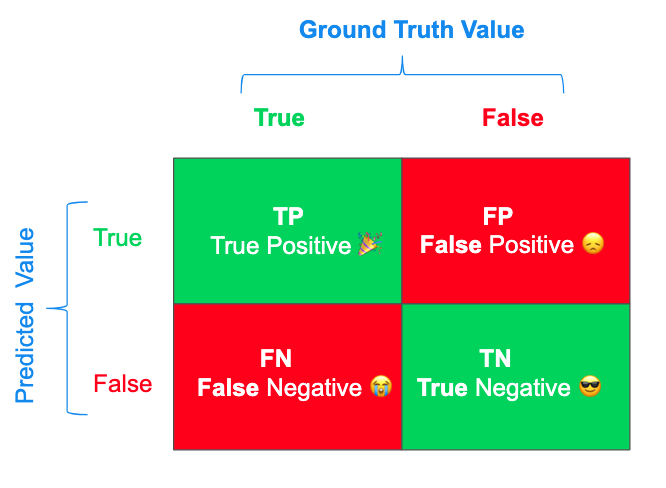

 * **Accuracy**- Classification accuracy is a metric that summarizes the performance of a classification model as the number of correct predictions divided by the total number of predictions. It is easy to calculate and intuitive to understand, making it the most common metric used for evaluating classifier.
 * **Precision**- The ability of a classification model to identify only the relevant data points. Mathematically, the number of true positives divided by the number of true positives plus the number of false positives.
 * **Recall**- The ability of a model to find all the relevant cases within a data set. Mathematically, we define recall as the number of true positives divided by the number of true positives plus the number of false negatives.
 * **F1-score**- The F-score, also called the F1-score, is a measure of a model's accuracy on a dataset.
 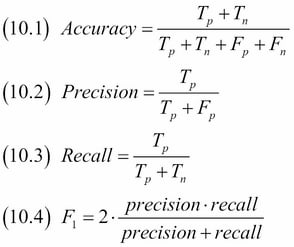

* **Threshold**- Part of choosing a threshold is assessing how much you'll suffer for making a mistake.
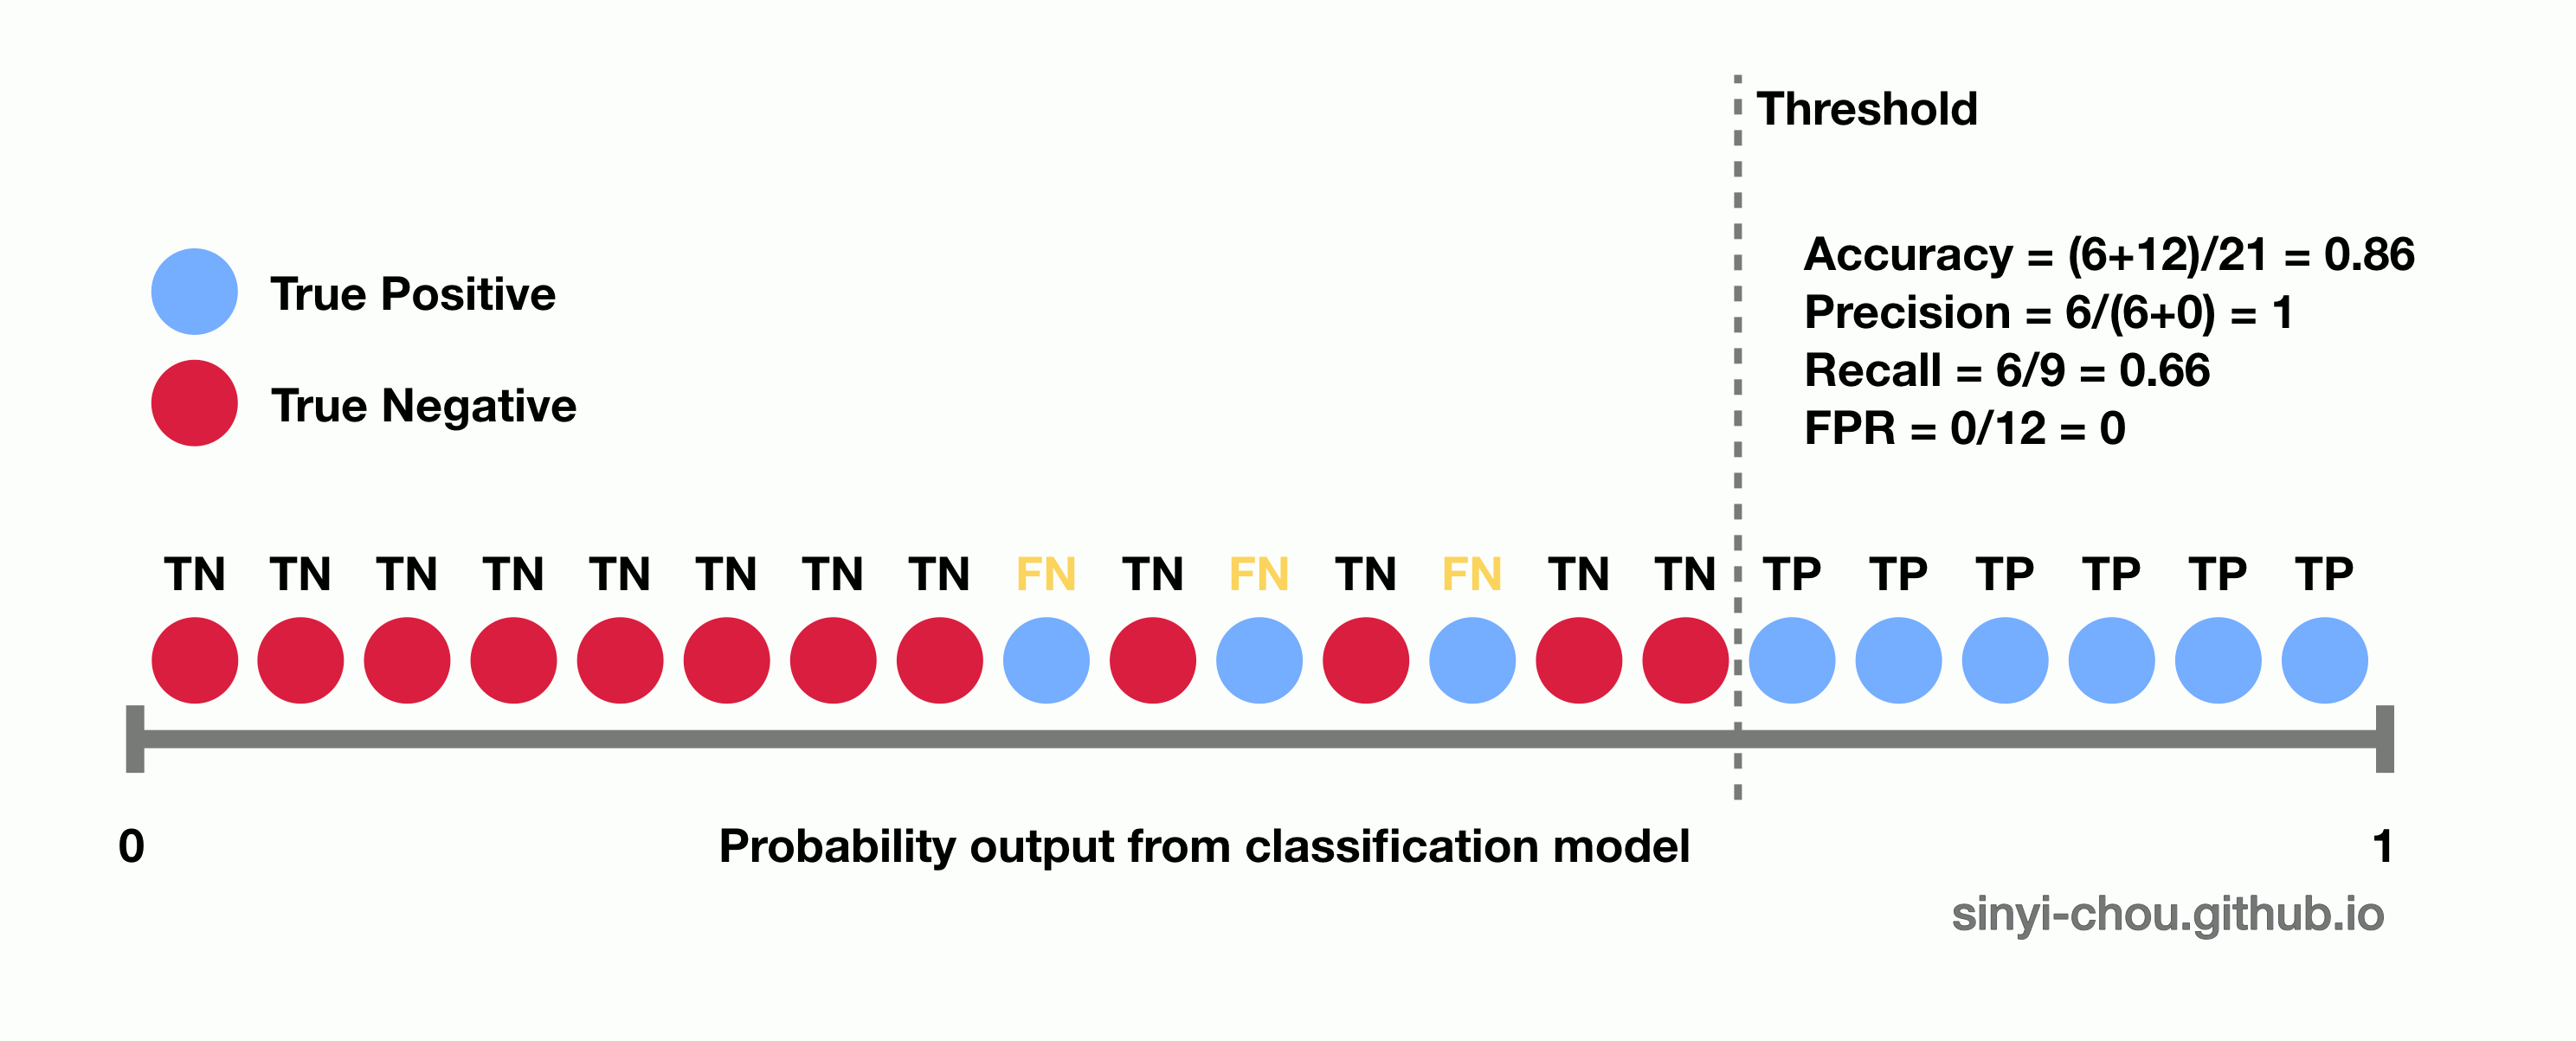

 * **ROC curve**- ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:
     * True Positive Rate.
     * False Positive Rate.

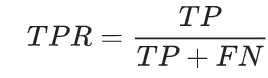

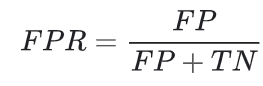

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve:
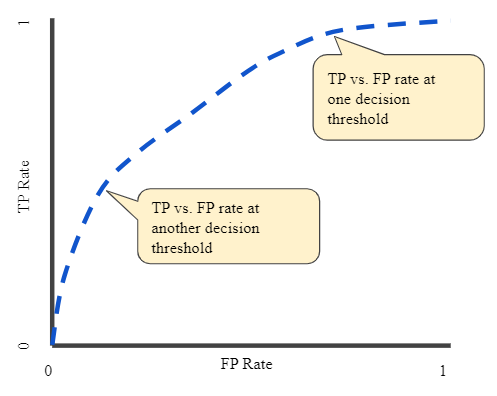

* **AUC**- AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).
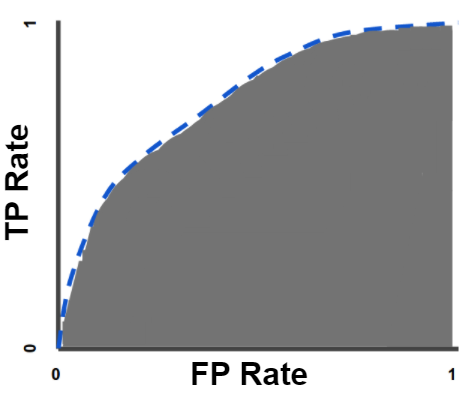

### Dummy Classifier
A dummy classifier is a type of classifier which does not generate any insight about the data and classifies the given data using only simple rules. ... It is used only as a simple baseline for the other classifiers i.e. any other classifier is expected to perform better on the given dataset

In [41]:
dm = DummyClassifier(strategy='most_frequent')
dm.fit(X_train_train,y_train_train)
y_pred = dm.predict(X_train_test)
dummy_acc = metrics.accuracy_score(y_train_test, y_pred)
dummy_acc

0.5615105413545447

As we said before, we have around 56.6% accuracy with our Dummy model. The reason we didn't got exactly 56.6% is because on a part of the data and not all of it.

Let's present the total scoring table:

In [42]:
print(classification_report(y_train_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72     14542
           1       0.00      0.00      0.00     11356

    accuracy                           0.56     25898
   macro avg       0.28      0.50      0.36     25898
weighted avg       0.32      0.56      0.40     25898



We can also see the model prediction distribution, using a confusion matrix:

<AxesSubplot:>

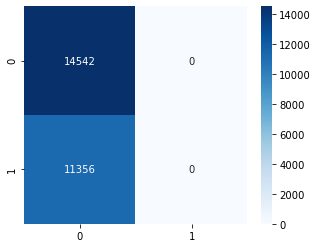

In [43]:
plt.figure(figsize=(5,4))
sb.heatmap(confusion_matrix(y_train_test, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

Let's present the ROC curve for the Dummy classifier:

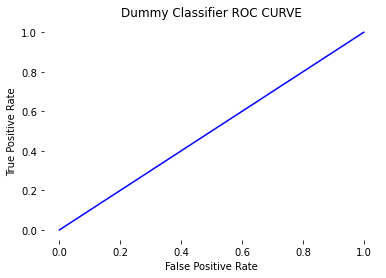

In [44]:
dummy_fpr, dummy_tpr, thresholds= roc_curve(y_train_test, y_pred)
auc = round(roc_auc_score(y_train_test, y_pred),3)*100
plt.plot(dummy_fpr, dummy_tpr, color='b')
plt.box(False)
plt.title('Dummy Classifier ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [45]:
print(f"The ROC Curve score is: {auc}%")

The ROC Curve score is: 50.0%


#### Cross validation

In [46]:
dummy_acc = cross_val_score(DummyClassifier(strategy='most_frequent'), X_train, y_train, cv = 10).mean()
dummy_acc

0.5652144537461569

### Logistic Regression
Logistic Regression is a classification technique used in machine learning. It uses a logistic function to model the dependent variable. The dependent variable is dichotomous in nature, i.e. there could only be two possible classes (eg.: either the person is satisfied or not).

In [47]:
lr = LogisticRegression()
lr.fit(X_train_train, y_train_train)
y_pred = lr.predict(X_train_test)
logistic_acc = metrics.accuracy_score(y_train_test, y_pred)
logistic_acc

0.8753571704378716

Let's present the total scoring table:

In [48]:
print(classification_report(y_train_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     14542
           1       0.87      0.84      0.86     11356

    accuracy                           0.88     25898
   macro avg       0.87      0.87      0.87     25898
weighted avg       0.88      0.88      0.88     25898



We can also see the model prediction distribution, using a confusion matrix:

<AxesSubplot:>

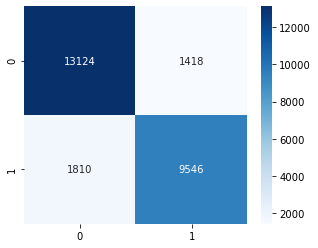

In [49]:
plt.figure(figsize=(5,4))
sb.heatmap(confusion_matrix(y_train_test, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

Let's present the ROC curve for the Logistic Regression:

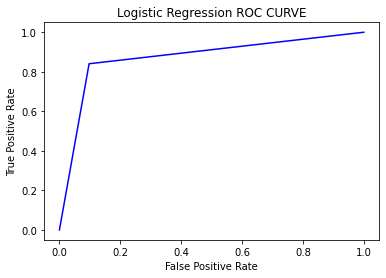

In [50]:
lr_fpr, lr_tpr, thresholds= roc_curve(y_train_test, y_pred)
auc = round(roc_auc_score(y_train_test, y_pred),3)*100
plt.plot(lr_fpr, lr_tpr, color='b')
plt.title('Logistic Regression ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [51]:
print(f"The ROC Curve score is: {auc}%")

The ROC Curve score is: 87.2%


#### Cross validation

In [52]:
logistic_acc = cross_val_score(LogisticRegression(), X_train, y_train, cv = 10).mean()
logistic_acc

0.8752377194906747

### KNN Classifier
KNN works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification).

In [53]:
knn = KNeighborsClassifier()
knn.fit(X_train_train, y_train_train)
y_pred = knn.predict(X_train_test)
knn_acc = metrics.accuracy_score(y_train_test, y_pred)
knn_acc

0.9287203645069118

Let's present the total scoring table:

In [54]:
print(classification_report(y_train_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94     14542
           1       0.95      0.88      0.92     11356

    accuracy                           0.93     25898
   macro avg       0.93      0.92      0.93     25898
weighted avg       0.93      0.93      0.93     25898



We can also see the model prediction distribution, using a confusion matrix:

<AxesSubplot:>

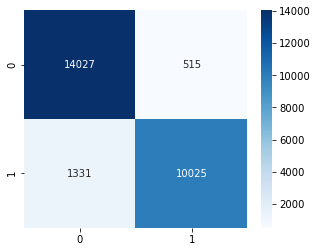

In [55]:
plt.figure(figsize=(5,4))
sb.heatmap(confusion_matrix(y_train_test, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

Let's present the ROC curve for the Logistic Regression:

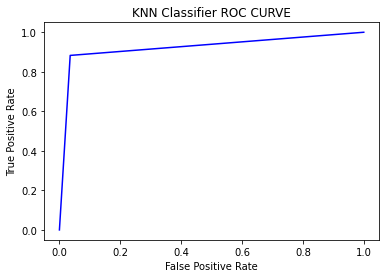

In [56]:
knn_fpr, knn_tpr, thresholds= roc_curve(y_train_test, y_pred)
auc = round(roc_auc_score(y_train_test, y_pred),3)*100
plt.plot(knn_fpr, knn_tpr, color='b')
plt.title('KNN Classifier ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Finding the best 'K' using **cross validation**

In [ ]:
index = 0
max_score = -sys.maxsize
for i in range(1,21):
    acc = cross_val_score(KNeighborsClassifier(n_neighbors = i), X_train, y_train, cv = 10).mean()
    if (acc > max_score):
        index = i
        max_score = acc
knn_acc = max_score
print(index, ":  ", max_score)

In [57]:
print(f"The ROC Curve score is: {auc}%")

The ROC Curve score is: 92.4%


### Random Forest
Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset.

In [58]:
rf = RandomForestClassifier(random_state=7)
rf.fit(X_train_train, y_train_train)
y_pred = rf.predict(X_train_test)
rf_acc = metrics.accuracy_score(y_train_test, y_pred)
rf_acc

0.9653255077612171

Let's present the total scoring table:

In [59]:
print(classification_report(y_train_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14542
           1       0.97      0.95      0.96     11356

    accuracy                           0.97     25898
   macro avg       0.97      0.96      0.96     25898
weighted avg       0.97      0.97      0.97     25898



We can also see the model prediction distribution, using a confusion matrix:

<AxesSubplot:>

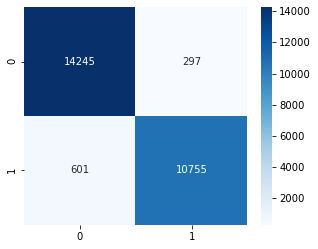

In [60]:
plt.figure(figsize=(5,4))
sb.heatmap(confusion_matrix(y_train_test, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

Let's present the ROC curve for the Random Forest:

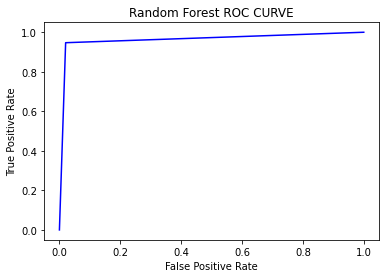

In [61]:
rf_fpr, rf_tpr, thresholds= roc_curve(y_train_test, y_pred)
auc = round(roc_auc_score(y_train_test, y_pred),3)*100
plt.plot(rf_fpr, rf_tpr, color='b')
plt.title('Random Forest ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [62]:
print(f"The ROC Curve score is: {auc}%")

The ROC Curve score is: 96.3%


#### Cross validation

In [63]:
rf_acc = cross_val_score(RandomForestClassifier(random_state=7), X_train, y_train, cv = 10).mean()
rf_acc

0.9639054180075286

We can also present all of the models ROC curves together:

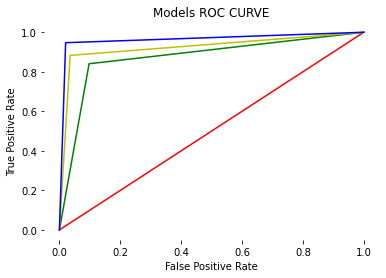

In [68]:
plt.plot(dummy_fpr, dummy_tpr, color='r')
plt.plot(lr_fpr, lr_tpr, color='g')
plt.plot(knn_fpr, knn_tpr, color='y')
plt.plot(rf_fpr, rf_tpr, color='b')
plt.box(False)
plt.title('Models ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Red - Dummy, Green - Logistic, Yellow - KNN, Blue - Random Forest.

From here, we can clearly see that the best model is **Random Forest Classifier**, let's improve it. 

## HyperParameters Tuning
For improvment, we will use GridSearchCV on our best model.

The GridSearchCV chooses parameters between all of the possible combinations we have given in 'param_grid'.

Evantually, we can see which parameters combination gives us the best score.

In [69]:
# number of trees in random forest
n_estimators_list = [100, 500, 1000, 3000]
# number of features to consider at every split
max_features_list = np.arange(0.01,0.2,0.01)
# number of samples
max_samples_list = [0.5,0.75,1.0]
params = {'n_estimators':n_estimators_list,
          'max_features':max_features_list,
          'max_samples':max_samples_list}
grid_model = GridSearchCV(estimator = RandomForestClassifier(random_state=7),
                              param_grid = params,
                              n_jobs = -1,
                              cv = 10)

In [ ]:
# fitting the training part
grid_model.fit(X_train, y_train)

In [ ]:
# The best parameters
best_parameters = grid_model.best_params_
print(best_parameters)

In [ ]:
# The best score
best_score = grid_model.best_score_
print("score: ",best_score)

In [ ]:
y_pred = grid_model.predict(X_test)
accRF = metrics.accuracy_score(y_test, y_pred)
accRF

Let's present the total scoring table:

In [ ]:
print(classification_report(y_test,y_pred))

We can also see the model prediction distribution, using a confusion matrix:

In [ ]:
plt.figure(figsize=(5,4))
sb.heatmap(confusion_matrix(y_test, y_pred), cmap = "Blues", annot=True, fmt = '.0f')

Let's present the ROC curve for the Grid Random Forest:

In [ ]:
f_p_r, t_p_r, _= roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred),3)*100
plt.plot(f_p_r, t_p_r, color='b')
plt.box(False)
plt.title('Random Forest ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
print(f"The ROC Curve score is: {auc}%")

# Conclusion

## Models score

In [ ]:
print("Dummy Classifier accuracy: ",dummy_acc)
print("Logistic Regression: ",logistic_acc)
print("KNN Classifier: ",knn_acc)
print("Random Forest Classifier: ",rf_acc)

The best model (between the models that we checked) for our dataset is: Random Forest Classifier

After a GridSearchCV we improved it and got the best HyperParameters.

Our test score is: ...